# Sync

In [6]:
!aws s3 sync resources/grn-benchmark s3://openproblems-data/resources/grn/grn-benchmark --delete
!aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models --delete
!aws s3 sync resources/prior/ s3://openproblems-data/resources/grn/prior --delete
# !aws s3 sync resources/supplementary/ s3://openproblems-data/resources/grn/supplementary --delete
# !aws s3 sync resources/results/ s3://openproblems-data/resources/grn/results --delete

upload: resources/grn_models/d0_hvg/scenicplus.csv to s3://openproblems-data/resources/grn/grn_models/d0_hvg/scenicplus.csv
upload: resources/prior/peaks.bed to s3://openproblems-data/resources/grn/prior/peaks.bed
upload: resources/prior/peaks.txt to s3://openproblems-data/resources/grn/prior/peaks.txt
upload: resources/prior/cell_topic_d0_hvg.csv to s3://openproblems-data/resources/grn/prior/cell_topic_d0_hvg.csv

The user-provided path resources/supplementary/ does not exist.


In [ ]:
!aws s3 sync s3://openproblems-data/resources/grn/grn-benchmark resources/grn-benchmark 
!aws s3 sync  s3://openproblems-data/resources/grn/grn_models resources/grn_models/
!aws s3 sync s3://openproblems-data/resources/grn/prior resources/prior/ 


# Import

In [6]:
import yaml
import os
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
import sys 
import subprocess
import io
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../')
from grn_benchmark.src.commons import surragate_names
def extract_data(data, reg='reg1', dataset_id='scgen_pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg
def process_data(RUN_ID, models_all=None):
    !aws s3 sync s3://openproblems-data/resources/grn/results/{RUN_ID} resources/results/{RUN_ID} 
    base_folder = f'resources/results/{RUN_ID}'
    result_file = f'{base_folder}/scores.yaml'
        

    with open(result_file, 'r') as file:
        data = yaml.safe_load(file)
    
    
    if models_all is None:
        df_reg1 = extract_data(data, reg='reg1')
        df_reg2 = extract_data(data, reg='reg2')
    else:
        df_reg1 = extract_data(data, reg='reg1').reindex(models_all)
        df_reg2 = extract_data(data, reg='reg2').reindex(models_all)
    # df_all = pd.concat([df_reg1, df_reg2], axis=1).fillna(0)
    # df_all_n = (df_all-df_all.min(axis=0))/(df_all.max(axis=0)-df_all.min(axis=0))
    # df_all['Rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
    df_all = pd.concat([df_reg1, df_reg2], axis=1)
    return df_all
def process_trace_seqera(trace):
    trace['model'] = pd.DataFrame(trace.name.str.split(':').to_list())[3] #TODO: number 3 might be different  
    trace = trace.groupby('model').apply(lambda df: df.sort_values(by='duration', ascending=False).iloc[0])[['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar', 'duration']]

    def convert_duration_to_hours(duration_str):
        import re
        hours, minutes, seconds = 0, 0, 0
        time_parts = re.findall(r'(\d+)([hms])', duration_str)
        for value, unit in time_parts:
            if unit == 'h':
                hours = int(value)
            elif unit == 'm':
                minutes = int(value)
            elif unit == 's':
                seconds = int(value)
        return (hours * 3600 + minutes * 60 + seconds)/3600
    def format_ram(row):
        value = float(row.split()[0])
        if 'GB' in row:
            value = value
        elif 'MB' in row:
            value = value/1000
        else:
            raise ValueError('Define')
        return value 

    for col in trace.columns:
        if col=='%cpu':
            trace[col] = trace[col].str.replace('%', '').astype(float)
        elif col=='duration':
            trace[col] = trace[col].apply(convert_duration_to_hours)
        else:
            trace[col] = trace[col].apply(format_ram)
    return trace 
def process_trace_local(job_ids_dict):
    def get_sacct_data(job_id):
        command = f'sacct -j {job_id} --format=JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize'
        output = subprocess.check_output(command, shell=True).decode()
        
        # Load the output into a DataFrame
        df = pd.read_csv(io.StringIO(output), delim_whitespace=True)
        df = df.iloc[[2]]
        return df
    def elapsed_to_hours(elapsed_str):
        time = elapsed_str.split('-')
        if len(time) > 1:
            day = int(time[0])
            time = time[1]
        else:
            day = 0
            time = time[0]
        h, m, s = map(int, time.split(':'))
        return day*24 + h + m / 60 + s / 3600
    for i, (name, job_id) in enumerate(job_ids_dict.items()):
        df = get_sacct_data(job_id)
        df.index = [name]
        if i==0:
            df_local = df
        else:
            df_local = pd.concat([df_local, df], axis=0)
        
    # Remove 'K' and convert to integers
    df_local['MaxRSS'] = df_local['MaxRSS'].str.replace('K', '').astype(int)
    df_local['MaxVMSize'] = df_local['MaxVMSize'].str.replace('K', '').astype(int)
    df_local['Elapsed'] = df_local['Elapsed'].apply(lambda x: (elapsed_to_hours(x)))

    # Convert MaxRSS and MaxVMSize from KB to GB
    df_local['MaxRSS'] = df_local['MaxRSS'] / (1024 ** 2)  # Convert KB to GB
    df_local['MaxVMSize'] = df_local['MaxVMSize'] / (1024 ** 2)  # Convert KB to GB
    return df_local
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores'
}



# Marco data 

In [4]:
# import subprocess
# import anndata as ad 
# import pandas as pd
# import numpy as np
# for cell_type in ['zhao', 'shalek', 'han', 'jackson']:
#     adata = ad.read_h5ad(f'resources_local/mccalla_extended/{cell_type}.h5ad')
#     adata.layers['norm'] = adata.X
#     adata.obs['cell_type'] = 'onecelltype'
#     adata.write(f'resources_local/mccalla_extended/{cell_type}.h5ad')
#     subsample = min([10000, len(adata)])
#     for GT in ['KDunion', 'chipunion', 'chipunion_KDUnion_intersect']:
#         GT_df = pd.read_csv(f'resources_local/mccalla_extended/{cell_type}_{GT}.csv')
#         gene_overlap = np.intersect1d(adata.var_names, GT_df.target.unique()).shape
#         print(f"{cell_type}-{GT}. adata shape: {adata.shape}, GT size: {GT_df.shape}, Gene overlap: {gene_overlap}")
#         command = f"viash run src/metrics/regression_1/config.vsh.yaml -- --perturbation_data resources_local/mccalla_extended/{cell_type}.h5ad --prediction resources_local/mccalla_extended/{cell_type}_{GT}.csv --layer norm --subsample {subsample} --apply_tf false --tf_all resources/prior/tf_all.csv --max_n_links -1 --verbose 1 --score output/{cell_type}_{GT}.h5ad"
#         subprocess.run(command, shell=True, check=True)

# Prior 

In [16]:
# !ls output/scglue/JASPAR2022-hg38.bed.gz
df = pd.read_csv('output/scglue/JASPAR2022-hg38.bed.gz', sep='\t')
df.columns = ['chr','start','end','tf']

In [26]:
df

,chr,start,end,tf
0,GL000008.2,327,344,ZNF684
1,GL000008.2,332,344,TEAD1
2,GL000008.2,332,344,TEAD2
3,GL000008.2,672,689,ZNF684
4,GL000008.2,782,795,NKX2-2
...,...,...,...,...
71562229,chrY,57217392,57217402,KLF16
71562230,chrY,57217393,57217403,KLF2
71562231,chrY,57217393,57217403,KLF6
71562232,chrY,57217405,57217415,KLF11


In [24]:
peaks = df['chr']+df['start'].astype(str)+df['end'].astype(str)

In [25]:
peaks.nunique()

62310613

In [13]:
# !ls resources/results/celloracle/output
# pd.read_csv('output/celloralce/')


celloracle


In [7]:
# df = pd.read_csv('output/scenicplus/qc/tss.bed', sep='\t')
# df.head(5)

In [4]:
# pd.read_csv('output/scenicplus/cell_topic.csv')

In [5]:
# adata_atac = ad.read_h5ad('resources/grn-benchmark/multiomics_atac_d0.h5ad')

In [5]:

if False:
    import re

    # Function to convert location string to BED format
    def convert_to_bed(locations, output_file='output.bed'):
        with open(output_file, 'w') as f:
            for loc in locations:
                # Use regex to extract chromosome, start, and end
                match = re.match(r"([^:]+):(\d+)-(\d+)", loc)
                if match:
                    chromosome, start, end = match.groups()
                    # BED format requires chrom, chromStart, chromEnd (0-based start)
                    bed_line = f"{chromosome}\t{int(start)-1}\t{end}\n"
                    f.write(bed_line)

    # Call the function with your location list
    convert_to_bed(adata.var_names[:1000], 'resources/prior/peaks.bed')

In [2]:
# !gimme motifs resources/prior/peaks.bed output/motifs -p HOMER --known -g ../../genomes_dir/hg38/hg38.fa
# !gimme motifs -h

In [1]:
# # Compare with default motifs in gimmemotifs
# from gimmemotifs.motif import default_motifs
# motifs =  default_motifs()

In [8]:
# !ls output/cisbp//pwms_all_motifs
# pd.read_csv('output/cisbp/pwms_all_motifs/M00008_2.00.txt', sep='\t')

,Pos,A,C,G,T
0,1,0.282959,0.248465,0.245993,0.222583
1,2,0.316659,0.184532,0.236944,0.261864
2,3,0.377778,0.112652,0.209413,0.300157
3,4,0.616393,0.068985,0.111484,0.203138
4,5,0.675764,0.042770,0.063171,0.218294
5,6,0.326032,0.133887,0.082023,0.458058
6,7,0.321153,0.137266,0.112384,0.429198


In [30]:
!ls output/scenic/databases
df = pd.read_feather('output/scenic/databases/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather')

hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Weight', ylabel='Cumulative Density'>)

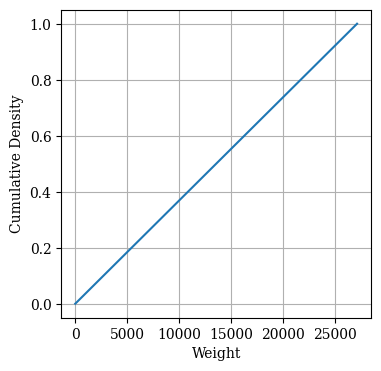

In [42]:
plot_cumulative_density(df.iloc[10, :-1].values)

# Run grn inference 

## Local runs

In [5]:
if True:
    par = {
        'methods': ['scenicplus'],
        'models_dir': 'resources/grn_models/',
        'multiomics_rna': 'resources/grn-benchmark/multiomics_rna.h5ad', 
        'multiomics_atac': 'resources/grn-benchmark/multiomics_atac.h5ad', 
        'num_workers': 20,
        'mem': "250G",
        'time': "48:00:00"
    }

    for method in par['methods']:
        par['prediction'] = f"{par['models_dir']}/{method}.csv"
        # method arguments 
        # method_args=f"--multiomics_rna {par['multiomics_rna']} --prediction {par['prediction']} --num_workers  {par['num_workers']} --resources_dir src/utils"
        method_args=f"--multiomics_rna {par['multiomics_rna']} --multiomics_atac {par['multiomics_atac']} --prediction {par['prediction']} --num_workers  {par['num_workers']} --resources_dir src/utils"

        # run command
        if method == "pearson_corr":
            command = f"python src/control_methods/pearson/script.py {method_args}"
        elif method == "celloracle":
            command = f"/home/jnourisa/miniconda3/envs/celloracle/bin/python src/methods/multi_omics/celloracle/script.py {method_args}"
        elif method in ["grnboost2", "scenic", "genie3"]:
            command = f"singularity exec ../../images/scenic python src/methods/single_omics/{method}/script.py {method_args}" 
        elif method == 'scglue':

            command = f"singularity exec ../../images/scglue python src/methods/multi_omics/{method}/script.py {method_args}"
        elif method == 'ppcor':
            command = f"singularity exec ../../images/ppcor Rscript src/methods/single_omics/{method}/script.R {method_args}"
        elif method == 'scenicplus':
            command = f"singularity exec ../../images/scenicplus python src/methods/multi_omics/{method}/script.py {method_args}"
        else:
            command = f"singularity exec ../../images/{method} python src/methods/single_omics/{method}/script.py {method_args}"
        # sbatch tags
        tag = f"--job-name {method} "
        resources = f" --cpus-per-task {par['num_workers']} --mem {par['mem']} --time {par['time']}" #resources
        tag+=resources
        if method=='scglue':
            tag += f" --partition=gpu --gres=gpu:1"
            
        !sbatch {tag} scripts/sbatch/grn_inference.sh "{command}" 
        # !bash scripts/sbatch/grn_inference.sh "{command}"     

Submitted batch job 7754915


## Baseline models

In [6]:
if False:
    command = f"--multiomics_rna {par['multiomics_rna']} --models_dir {par['models_dir']}"
    !python src/control_methods/script_all.py {command}

## Seqera

In [7]:
if False: # submit the job
    !bash src/methods/multi_omics/celloracle/run.sh
if False: # get the results
    !aws s3 sync s3://openproblems-data/resources/grn/results/celloracle resources/results/celloracle

In [8]:
if False: # process celloracle
    # - prediction 
    # !mv resources/results/celloracle/celloracle.grn_inference_celloracle.prediction.csv resources/results/celloracle/celloracle.csv 
    !cp resources/results/celloracle/celloracle.csv  {par['models_dir']}/celloracle.csv
    !ls {par['models_dir']}
    
    # -  peak - gene
    # !mkdir resources/grn_models/peak_gene/
    df = pd.read_csv("resources/results/celloracle/output/celloracle/base_grn.csv")[['peak_id','gene_short_name']]
    df.columns = ['peak','target']
    df.to_csv('resources/grn_models/peak_gene/celloracle.csv')

# Scores
While we run baseline models using the below commands, for the rest of the models, they must be ran already and their predictions should be given in the relevant folder.

## Calculate scores

In [9]:
# consensus: run this after updating method list
if False:
    model_names = ' '.join(par['methods'])
    command = [
        "python", 
        "src/metrics/regression_2/consensus/script.py", 
        "--models_dir", par['models_dir'], 
        "--models"
    ] + model_names.split()

    # Print command to verify
    subprocess.run(command)

In [3]:
# run calculating scores
if False:
    !bash scripts/sbatch/calculate_scores.sh #includes both reg1 and 2. #inside the script, set the reg_type, read and write dirs, and methods
    # !sbatch scripts/sbatch/calculate_scores.sh #includes both reg1 and 2. #inside the script, set the reg_type, read and write dirs, and methods

## Process scores

In [11]:
## full dataset: ridge
df_scores = pd.read_csv(f"resources/scores/scgen_pearson-ridge.csv", index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,-0.100238,-0.211182,0.489316,0.514896,11
negative_control,-0.044574,-0.045158,0.445727,0.501389,9
positive_control,0.197129,0.578822,0.530848,0.584694,3
pearson_corr,0.273443,0.516343,0.639871,0.549188,2
portia,0.263310,0.357006,0.527132,0.538593,5
ppcor,0.017954,0.159754,0.317136,0.506147,8
grnboost2,0.421936,0.489322,0.825025,0.619527,1
scenic,0.168006,0.218916,0.521234,0.583202,6
granie,0.083298,0.106012,0.323324,0.458506,10
scglue,0.098187,0.270489,0.419325,0.537654,7


In [12]:
## d0_hvgs: ridge
df_scores = pd.read_csv('resources/scores/d0_hvg/scgen_pearson-ridge.csv', index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,-0.100238,-0.211182,0.489316,0.514896,10
negative_control,-0.039305,-0.041004,0.195831,0.505943,11
positive_control,0.197129,0.578822,0.530848,0.584694,4
pearson_corr,0.269379,0.509297,0.750452,0.542506,3
portia,0.148941,0.227248,0.451256,0.518048,7
ppcor,0.022846,0.094107,0.396680,0.509874,9
genie3,0.372641,0.490357,0.754073,0.576580,2
grnboost2,0.381032,0.459860,0.781852,0.609075,1
scenic,0.147553,0.214694,0.600839,0.574294,6
scglue,0.078309,0.238859,0.448617,0.527076,8


In [13]:

# GB
# df_scores_GB = pd.read_csv("resources/scores/hvg_GB.csv", index_col=0)
# df_all_n = (df_scores_GB-df_scores_GB.min(axis=0))/(df_scores_GB.max(axis=0)-df_scores_GB.min(axis=0))
# df_scores_GB['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
# df_scores_GB.style.background_gradient()

# Format resourcs used

## d0_hvgs

In [14]:
# HVGs: extract resources local jobs
job_ids_dict_hvg = {
    'portia': 7744548,
    'grnboost2': 7742249,
    'scenic': 7742283,
    'genie3': 7742285,
    'ppcor': 7742364,
    'scglue': 7742343,
}
    
df_local = process_trace_local(job_ids_dict_hvg)
df_local

,JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize
portia,7744548.bat+,batch,20,0.153611,COMPLETED,5.854904,6.284901
grnboost2,7742249.bat+,batch,20,1.568056,COMPLETED,3.067471,3.563801
scenic,7742283.bat+,batch,20,1.908056,COMPLETED,30.356461,32.573463
genie3,7742285.bat+,batch,20,16.682500,COMPLETED,13.105103,13.563530
ppcor,7742364.bat+,batch,20,0.556667,COMPLETED,3.909119,4.283978
scglue,7742343.bat+,batch,20,4.380278,FAILED,29.917423,35.933720


In [15]:
# sequera 
if False:
    models = ['pearson_causal', 'pearson_corr', 'positive_control']
    base_dir = 'resources/results/d0_hvgs_baseline'
    trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')

    trace_baselines = process_trace_seqera(trace)

    models = ['celloracle']
    base_dir = 'resources/results/celloracle_d0_hvgs'
    trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')
    trace_models = process_trace(trace)


    trace_seqera = pd.concat([trace_baselines, trace_models], axis=0)
    map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

    trace_seqera = trace_seqera[map_dict.keys()]
    trace_seqera.columns = trace_seqera.columns.map(map_dict)
    
    trace_seqera.to_csv('resources/results/trace/trace_seqera_hvg.csv')
    trace_seqera
else:
    trace_seqera = pd.read_csv('resources/results/trace/trace_seqera_hvg.csv', index_col=0)
trace_seqera


,MaxRSS,Elapsed
model,,
pearson_causal,0.9747,0.064167
pearson_corr,0.9751,0.072500
positive_control,4.9000,0.075278
celloracle,14.9000,1.472222


In [16]:
# merge local and cluster dfs 
map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

df_local = df_local[map_dict.values()]

df_res = pd.concat([trace_seqera, df_local], axis=0)

df_res.columns = ['Peak memory (GB)', 'Duration (hour)']

df_res.to_csv('resources/results/trace/trace_hvg.csv')

df_res

,Peak memory (GB),Duration (hour)
pearson_causal,0.974700,0.064167
pearson_corr,0.975100,0.072500
positive_control,4.900000,0.075278
celloracle,14.900000,1.472222
portia,5.854904,0.153611
grnboost2,3.067471,1.568056
scenic,30.356461,1.908056
genie3,13.105103,16.682500
ppcor,3.909119,0.556667
scglue,29.917423,4.380278


## Full dataset

In [17]:
# extract resources local jobs
job_ids_dict = {
    'portia': 7751292,
    'grnboost2': 7747906,
    'scenic': 7748219,
    'ppcor': 7748321,
    'scglue': 7751242,
}
   
df_local = process_trace_local(job_ids_dict)
df_local

,JobID,JobName,AllocCPUS,Elapsed,State,MaxRSS,MaxVMSize
portia,7751292.bat+,batch,20,2.491111,COMPLETED,54.874477,55.685230
grnboost2,7747906.bat+,batch,20,7.510556,COMPLETED,6.981808,7.378796
scenic,7748219.bat+,batch,20,24.008611,CANCELLED,32.937546,35.954300
ppcor,7748321.bat+,batch,20,13.425833,COMPLETED,63.609119,64.136433
scglue,7751242.bat+,batch,20,7.482778,COMPLETED,29.151573,37.841366


In [18]:
# get seqera 
model = 'celloracle'
base_dir = f'resources/results/{model}'
trace = pd.read_csv(f'{base_dir}/trace.txt', sep='\t')
trace_seqera = process_trace_seqera(trace)
trace_seqera.index = [model]

map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

trace_seqera = trace_seqera[map_dict.keys()]
trace_seqera.columns = trace_seqera.columns.map(map_dict)

trace_seqera

/vol/tmp/users/jnourisa/ipykernel_2219274/2618087525.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trace = trace.groupby('model').apply(lambda df: df.sort_values(by='duration', ascending=False).iloc[0])[['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar', 'duration']]


,MaxRSS,Elapsed
celloracle,45.4,3.8075


In [19]:
# merge local and cluster dfs 
map_dict = {'peak_rss':'MaxRSS', 'duration':'Elapsed'}

df_local = df_local[map_dict.values()]

df_res = pd.concat([trace_seqera, df_local], axis=0)

df_res.columns = ['Peak memory (GB)', 'Duration (hour)']

df_res

,Peak memory (GB),Duration (hour)
celloracle,45.400000,3.807500
portia,54.874477,2.491111
grnboost2,6.981808,7.510556
scenic,32.937546,24.008611
ppcor,63.609119,13.425833
scglue,29.151573,7.482778


## Merge scores with resources

In [20]:
df_res = pd.read_csv('resources/results/trace/trace_hvg.csv', index_col=0)
df_scores = pd.read_csv('resources/results/scores/d0_hvg/scgen_pearson-ridge.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'resources/results/scores/d0_hvg/scgen_pearson-ridge.csv'

In [14]:
# create ranking 
df_scores = df_scores.fillna(0)
df_scores[df_scores < 0]=0
df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['overall_score'] = df_scores.mean(axis=1)
# df_scores['rank'] = df_scores.mean(axis=1).rank(ascending=False).astype(int)

df_all = pd.concat([df_scores, df_res], axis=1)
df_all = df_all.fillna(0)
df_all.index.name = 'method_name' 
df_all = df_all.reset_index()

df_all 


,method_name,S1,S2,static-theta-0.0,static-theta-0.5,overall_score,Peak memory (GB),Duration (hour)
0,collectri,0.000000,0.000000,0.500809,0.086811,0.146905,0.000000,0.000000
1,negative_control,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,positive_control,0.517356,1.000000,0.571681,0.763590,0.713157,4.900000,0.075278
3,pearson_corr,0.706973,0.879884,0.946418,0.354523,0.721949,0.975100,0.072500
4,portia,0.390888,0.392604,0.435863,0.117372,0.334182,5.854904,0.153611
5,ppcor,0.059957,0.162584,0.342733,0.038118,0.150848,3.909119,0.556667
6,genie3,0.977976,0.847163,0.952597,0.684918,0.865663,13.105103,16.682500
7,grnboost2,1.000000,0.794475,1.000000,1.000000,0.948619,3.067471,1.568056
8,scenic,0.387244,0.370915,0.691114,0.662750,0.528006,30.356461,1.908056
9,scglue,0.205518,0.412663,0.431359,0.204913,0.313613,29.917423,4.380278


## Summary figure

In [40]:

summary_file = "output/summary_d0_hvg.tsv"
summary_figure = "output/summary_d0_hvg_figure.pdf"

df_all['memory_log'] = np.log(df_all['Peak memory (GB)']+1)
df_all['memory_log'] = np.max(df_all['memory_log'])-df_all['memory_log']


df_all["duration_log"] = np.log(df_all['Duration (hour)']+1)
df_all['duration_log'] = np.max(df_all['duration_log'])-df_all['duration_log']

df_all["duration_str"] = df_all['Duration (hour)'].round(1).astype(str)
df_all['memory_str'] =  df_all['Peak memory (GB)'].round(1).astype(str)


df_all.to_csv(summary_file, sep='\t')

!Rscript ../grn_benchmark/src/metrics_figure.R {summary_file} {summary_figure}


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (12): ...1, S1, S2, static-theta-0.0, static-theta-0.5, overall_score, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 10 × 7
   id               id_color         name       group geom  palette options     
   <c

# All layers

In [60]:
np.arange(0, 1, .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [17]:
base_dir = 'resources/scores/d0_hvg'
layers = ['lognorm','pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']
reg_type = 'ridge'
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, layer in enumerate(layers):
    df = pd.read_csv(f'{base_dir}/{layer}-{reg_type}.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:layer})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:layer})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T

reg1_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg1_scores_layers_hvgs.csv')
reg2_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg2_scores_layers_hvgs.csv')

reg1_scores_layers.style.background_gradient()


,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
lognorm,-0.050548,-0.042234,0.082101,0.046997,0.014856,0.003078,0.073206,0.091619,0.068810,0.027315,0.068165
pearson,-0.095474,-0.041130,0.163470,0.217511,0.113185,0.016686,0.295920,0.299160,0.117241,0.061848,0.171422
seurat_lognorm,-0.052159,-0.041432,0.087152,0.053505,0.017466,0.003723,0.081703,0.105108,0.079217,0.031597,0.078648
seurat_pearson,-0.095343,-0.041747,0.174773,0.219817,0.108111,0.016615,0.293678,0.301832,0.122765,0.064890,0.181489
scgen_lognorm,-0.059849,-0.041816,0.160466,0.094411,0.055487,0.008795,0.162319,0.219727,0.147812,0.060572,0.150424
scgen_pearson,-0.100238,-0.039305,0.197129,0.269379,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897


In [21]:
base_dir = 'resources/scores/'
layers = ['lognorm','pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']
reg_type = 'ridge'
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, layer in enumerate(layers):
    df = pd.read_csv(f'{base_dir}/{layer}-{reg_type}.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:layer})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:layer})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T

reg1_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg1_scores_layers.csv')
reg2_scores_layers.to_csv('../grn_benchmark/results_folder/scores/reg2_scores_layers.csv')

reg1_scores_layers.style.background_gradient()


,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle
lognorm,-0.050548,-0.043757,0.082101,0.062031,0.010746,0.001611,0.118505,0.075060,0.044887,0.035910,0.069066
pearson,-0.095474,-0.043600,0.163470,0.222177,0.082329,0.014658,0.332626,0.130075,0.070551,0.079671,0.167634
seurat_lognorm,-0.052159,-0.044382,0.087152,0.068895,0.011506,0.002132,0.135575,0.080760,0.049640,0.039661,0.080605
seurat_pearson,-0.095343,-0.042833,0.174773,0.226611,0.087287,0.016914,0.339841,0.136727,0.075773,0.079768,0.174873
scgen_lognorm,-0.059849,-0.044936,0.160466,0.117994,0.029785,0.005762,0.263282,0.152383,0.090862,0.071800,0.153270
scgen_pearson,-0.100238,-0.044574,0.197129,0.273443,0.101110,0.017954,0.421936,0.172085,0.083298,0.099859,0.209151


# Robustness analysis

In [54]:
# !python src/robustness_analysis/script_all.py
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh

Submitted batch job 7752429


## Permute

In [2]:
# net 
noise_type = 'net'
base_dir = 'resources/results/robustness_analysis'
degrees = [0, 10, 20, 50, 100]
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, degree in enumerate(degrees):
    df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T
reg1_scores_layers.style.background_gradient()


FileNotFoundError: [Errno 2] No such file or directory: 'resources/results/robustness_analysis/net-0-scores.csv'

In [48]:
reg2_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,0.514896,0.505002,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
10,0.515406,0.505691,0.571882,0.523067,0.555572,0.524393,0.516036,0.570821,0.601759,0.565942,0.530801,0.573236
20,0.511172,0.504663,0.555954,0.526195,0.552449,0.515956,0.515292,0.569976,0.596415,0.561619,0.526821,0.563653
50,0.511803,0.495854,0.552935,0.524744,0.534764,0.516056,0.510711,0.556661,0.581920,0.548328,0.518366,0.542993
100,0.505540,0.503372,0.531005,0.513729,0.523002,0.506760,0.513287,0.504832,0.514585,0.504093,0.506443,0.513158


In [3]:
noise_type = 'sign'
base_dir = 'resources/results/robustness_analysis'
degrees = [0, 10, 20, 50, 100]
reg1_metric = 'S1'
reg2_metric = 'static-theta-0.5'
for i, degree in enumerate(degrees):
    df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
    df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
    df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
    
    if i == 0:
        reg1_scores_layers = df_reg1
        reg2_scores_layers = df_reg2
    else:
        reg1_scores_layers = pd.concat([reg1_scores_layers, df_reg1], axis=1)
        reg2_scores_layers = pd.concat([reg2_scores_layers, df_reg2], axis=1)
    
reg1_scores_layers = reg1_scores_layers.T
reg2_scores_layers = reg2_scores_layers.T
reg1_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,-0.100238,-0.043795,0.489147,0.238664,0.355256,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897
10,-0.107958,-0.042199,0.433246,0.170612,0.297354,0.103448,0.018551,0.309243,0.320476,0.105850,0.051565,0.148519
20,-0.129616,-0.042258,0.383169,0.109502,0.259201,0.064159,-0.001810,0.203046,0.229562,0.067477,0.026945,0.080443
50,-0.154785,-0.040425,-0.091824,-0.000377,-0.188567,-0.090789,-0.013036,-0.114169,-0.122291,-0.025912,-0.010141,-0.135087
100,-0.100238,-0.043795,0.489147,0.238664,0.355256,0.148941,0.022846,0.372641,0.381032,0.147553,0.078309,0.216897


In [4]:
reg2_scores_layers.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,pearson_causal,portia,ppcor,genie3,grnboost2,scenic,scglue,celloracle
0,0.514896,0.505002,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
10,0.514113,0.504708,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
20,0.513857,0.505899,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
50,0.512082,0.506397,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147
100,0.508349,0.508202,0.574608,0.524232,0.560490,0.518048,0.509874,0.576580,0.609075,0.574294,0.527076,0.580147


# repo

In [ ]:
# if par['metacell']:
#     print('metacell')
#     def create_meta_cells(df, n_cells=15):
#         meta_x = []
#         for i in range(0, df.shape[0], n_cells):
#             meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
#         df = pd.DataFrame(meta_x, columns=df.columns)
#         return df
            
#     adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
#     adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
#     adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
#     df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
#     X = df.values
#     var = pd.DataFrame(index=df.columns)
#     obs = df.reset_index()[['cell_type','donor_id']]
#     multiomics_rna = ad.AnnData(X=X, obs=obs, var=var)